<a href="https://colab.research.google.com/github/cafalchio/EXvivo/blob/main/EEG_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading data format Intan .dat

In [ ]:
!pip install MNE -q

In [ ]:
import glob, os
import mmap
from tqdm.notebook import tqdm
import sys
import pandas as pd
import numpy as np
import mne

import matplotlib.pyplot as plt
# import zipfile
import struct
from resource import getrusage, RUSAGE_SELF
import gc
gc.enable()
# load data
sys.path.append("/content/drive/MyDrive/aHuman_data_Mark/load_intan_rhd_format/")
from load_intan_rhd_format import *

from scipy import signal


## Intan to Buzsaki64A channel map

In [2]:
probe_amp_map = {
    '041':	0,
    '038':	1,
    '043':	2,
    '037':	3,
    '039':	4,
    '036':	5,
    '040':	6,
    '045':	7,
    '042':	8,
    '047':	9,
    '044':	10,
    '049':	11,
    '046':	12,
    '051':	13,
    '048':	14,
    '053':	15,
    '034':	16,
    '064':	17,
    '035':	18,
    '058':	19,
    '062':	20,
    '063':	21,
    '033':	22,
    '056':	23,
    '060':	24,
    '061':	25,
    '054':	26,
    '059':	27,
    '057':	28,
    '052':	29,
    '055':	30,
    '050':	31,
    '010':	32,
    '015':	33,
    '008':	34,
    '013':	35,
    '011':	36,
    '006':	37,
    '005':	38,
    '004':	39,
    '032':	40,
    '009':	41,
    '003':	42,
    '002':	43,
    '030':	44,
    '007':	45,
    '031':	46,
    '001':	47,
    '017':	48,
    '012':	49,
    '019':	50,
    '014':	51,
    '021':	52,
    '016':	53,
    '023':	54,
    '018':	55,
    '025':	56,
    '020':	57,
    '026':	58,
    '029':	59,
    '022':	60,
    '028':	61,
    '024':	62,
    '027':	63
    }

chunks = [{ 
        0:'041',
        1:'038',
        2:'043',
        3:'037',
        4:'039',
        5:'036',
        6:'040',
        7:'045'},
{
        8:'042',
        9:'047',
        10:'044',
        11:'049',
        12:'046',
        13:'051',
        14:'048',
        15:'053'},
{
        16:'034',
        17:'064',
        18:'035',
        19:'058',
        20:'062',
        21:'063',
        22:'033',
        23:'056'},

{
        24:'060',
        25:'061',
        26:'054',
        27:'059',
        28:'057',
        29:'052',
        30:'055',
        31:'050'},

{
        32:'010',
        33:'015',
        34:'008',
        35:'013',
        36:'011',
        37:'006',
        38:'005',
        39:'004'},

{ 
        40:'032',
        41:'009',
        42:'003',
        43:'002',
        44:'030',
        45:'007',
        46:'031',
        47:'001'},
{ 
        48:'017',
        49:'012',
        50:'019',
        51:'014',
        52:'021',
        53:'016',
        54:'023',
        55:'018'},
{
        56:'025',
        57:'020',
        58:'026',
        59:'029',
        60:'022',
        61:'028',
        62:'024',
        63:'027'}]

def chunk_to_channels(c, group = 'A'):
    chunk = chunks[c]
    return [group + '-' + chunk[key] for key in chunk.keys()]

## **Read metadata from recording**

Need the channel distribuition of the probe!!


Todo:
<ul>
    <li>Open channels by name or group</li>
    <li>Create MNE objects for EEG</li>
    <li>Bandpass </li

</ul>

Discover the distances between channels or probe configuration

Auxiliary functions

In [ ]:
def butter_filter(data, sample_frequency = 25000., freqs=300, filttype = 'highpass', plot_response = False):
    """
    Filter using bidirectional zero-phase shift Butterworth filter.
    Parameters
    ----------
    data : ndarray
        Data or signal to filter
    sample_frequency : Sampling frequency

    wp :
        Arguments with filter paramters
    Returns
    -------
    ndarray
        Filtered signal
    """
    gstop = 20  # minimum dB attenuation at stopabnd
    gpass = 3  # maximum dB loss during ripple
    nyquist = sample_frequency / 2
    
    if filttype == 'lowpass':
        wp = freqs / nyquist
        ws = min([wp + 0.1, 1])
    elif filttype == 'highpass':
        wp = freqs / nyquist
        ws = max([wp - 0.1, 0.01 / nyquist])
    elif filttype == 'bandpass':
        wp = [freq / nyquist for freq in freqs] 
        ws = np.zeros_like(wp)
        ws[0] = max([wp[0] - 0.1, 0.01 / nyquist])
        ws[1] = min([wp[1] + 0.1, 1])
    min_order, min_wp = signal.buttord(wp, ws, gpass, gstop)
    b, a = signal.butter(min_order, min_wp, btype=filttype, output='ba')
    
    freq, h = signal.freqz(b, a, fs=sample_frequency)
    
    # Plot
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
    ax[0].set_title("Frequency Response")
    ax[0].set_ylabel("Amplitude (dB)", color='blue')
    # ax[0].set_xlim([freqs[0], freq[1]*.3])
    ax[0].set_ylim([-25, 10])
    ax[0].grid()
    ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
    ax[1].set_ylabel("Angle (degrees)", color='green')
    ax[1].set_xlabel("Frequency (Hz)")
    # ax[1].set_xlim([0, freqs*10])
    ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
    ax[1].set_ylim([-90, 90])
    ax[1].grid()
    plt.show()
    print(f"\nwp: {wp} \nws: {ws}\norder: {min_order}")

    return signal.filtfilt(b, a, data)

In [ ]:
class Recording:
    '''class that reads metadata from a intan recording. It will scan a folder
    to find all data files and metadata.
    Ex: record = Recording(path to data)
    '''
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.info = glob.glob(path_to_data+'/*.rhd')[0]
        self.metadata = read_data(glob.glob(path_to_data+'/info.rhd')[0])
        self.sample_rate = self.metadata['frequency_parameters']['amplifier_sample_rate']
        self.time = glob.glob(path_to_data+'/time.dat')[0]
        self.data_files = sorted(glob.glob(path_to_data+'/amp*.dat'))
        self.aux_files = sorted(glob.glob(path_to_data+'/aux*.dat'))
        self.board_files = sorted(glob.glob(path_to_data+'/board*.dat'))
        self.vdd_files = glob.glob(path_to_data+'/vdd*.dat')
        self.channels = self.set_amp_files()
        self.channel_names = self.channels.keys()
        self.n_samples, self.timestamp = self.read_timestamp()
        self.data = np.array([], np.int16)
        print(f'Found in folder {len(self.data_files)} amplifier channels')
        print(f'Found in folder {len(self.aux_files)} axiliary channels')
    
    def set_amp_files(self):
        channels = {}
        for channel in self.metadata['amplifier_channels']:
            channel_name = channel['custom_channel_name']  
            channels[channel_name] = glob.glob(f'{self.path_to_data}/amp-{channel_name}.*')[0]
        return channels

    def read_timestamp(self):
        '''Function that reads timestamp from Intan recording'''
        size = os.path.getsize(self.time)
        num_samples = size/4
        n_samples = num_samples
        timestamp = np.fromfile(self.time, dtype=np.int32)
        timestamp = timestamp/self.sample_rate
        print(f'Reading {len(timestamp)/(60 * self.sample_rate):.2f} minutes of recording.')
        return int(n_samples), timestamp

    def read_channel(self, channel_idx):
        '''Function that reads a single recording channel'''
        channel_file = self.channels[channel_idx]
        # print(f"Reading: {self.data_files[channel_idx].split('/')[-1]}")
        size = os.path.getsize(channel_file)
        num_samples = size/(1 * 2)
        if num_samples != self.n_samples:
            print('Error reading file, missing samples!')
        data_ch = np.fromfile(channel_file, dtype=np.int16)
        self.data = data_ch * 0.195
        self.get_memory_use()
        return self.data
    
    def plot_raw_sample(self):
        ax = plt.figure(figsize=(20,6))
        ax = plt.plot(1/self.timestamp[25000:50000], self.data[25000:50000])
        ax = plt.ylabel('Voltage uV')
        ax = plt.xlabel('Time (s)')
        plt.show()
        plt.close()
    
    @staticmethod
    def get_memory_use():
        '''Auxiliary function to check memory use
        '''
        mem = getrusage(RUSAGE_SELF).ru_maxrss/1024000
        print(f'Memory use: {mem:.1f}Gb')
    
    def load_amp_channels(self, ch_idxs):
        '''
        Read a list of channels and transform from microvolts to volts
        '''
        res = [self.read_channel(ch_idx)/1000000 for ch_idx in ch_idxs] # from microvolts to volts
        # self.get_memory_use()
        return res
    
    def load_mne_channels(self, ch_idxs):
        ''' Load channels by its name ex(A-001) and 
        transform the EEG to MNE objects, can open 20 
        EEGs per time. It is recommended to open 
        a chunk of 8 files at time
        '''
        # freqs = (50, 100, 150, 200, 250)
        data = self.load_amp_channels(ch_idxs)
        ch_types = len(ch_idxs) * ['eeg']
        info = mne.create_info(ch_names=ch_idxs, sfreq=self.sample_rate, ch_types=ch_types)
        data =  mne.io.RawArray(np.array(data), info, verbose='ERROR')
        data = data.notch_filter(np.arange(50, 251, 50)) # Filter 50Hz
        # data = data.filter(l_freq=1, h_freq=200)
        # print('Removing 50Hz and resample to 2.4Khz')
        # data = data.resample(sfreq=600)
        self.get_memory_use()
        print('Done!')
        return data

In [ ]:
# Load the data folder
rec = Recording('/content/drive/MyDrive/aHuman_data_Mark/human_151126_135612/')


Reading Intan Technologies RHD2000 Data File, Version 1.4

n signal groups 7
Found 110 amplifier channels.
Found 6 auxiliary input channels.
Found 2 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

Header file contains no data.  Amplifiers were sampled at 25.00 kS/s.
Done!  Elapsed time: 0.0 seconds
Reading 46.15 minutes of recording.
Found in folder 110 amplifier channels
Found in folder 6 axiliary channels


In [ ]:
# read a data channel
raw_data = rec.load_mne_channels([
                                   'A-000', 'A-001',#'A-002', 'A-003', 'A-004', 
                                #   'C-005', 'C-006', 'A-007', 'A-008', 'A-009',
                                  #'A-012', 'A-011', #'A-012', 
                                #   'C-001', 'C-004'
                                  ])

Memory use: 13.2Gb
Memory use: 13.2Gb
Memory use: 13.2Gb
Done!


In [ ]:
%%time
# bandpass filter
raw_data =  raw_data.copy().filter(l_freq = 1, h_freq=800)
# raw_data = raw_data.resample(5000)

CPU times: user 11.5 s, sys: 195 ms, total: 11.7 s
Wall time: 11.6 s


In [ ]:
data = raw_data.get_data(0)[0] -  raw_data.get_data(1)[0]
# data = data - data.mean() / data.std()



In [ ]:
def plot_raw(wave, fs=25000, size = 10):

    t_window = int(size*60*fs)
    lenght = len(wave)
    n_fig = int(lenght / t_window) # number of figures of lenght t_window
    r_window = lenght % t_window # rest of samples window
    extra = 1 if r_window != 0 else 0
    n_fig = n_fig + extra
    x = np.linspace(0, data.size/10 , data.size)
    fig, axs = plt.subplots(n_fig+extra, 1, figsize=(20, (n_fig+1) * 3))
    for i in range(n_fig):
        if i < n_fig -1:
            part_wave = wave[i * t_window : i * t_window + t_window]
        else:
            part_wave = wave[i * t_window :]
        if i == 0: 
            axs[i].title.set_text(f'Data plot windows of {size} minutes')
        # x = np.linspace(i*size, size+i*size, part_wave.size)
        axs[i].plot(part_wave)
        # axs[i].set_xlim(0, 10)
        axs[i].set_ylim(-5e-5, 5e-5)
        axs[i].get_yaxis().set_ticks([])
        axs[i].ticklabel_format(axis='x', style='plain', useOffset= -i * t_window, useMathText=True)
        # axs[i].set_ylabel('uV')
    axs.flat[-1].set_visible(False)
    fig.tight_layout()
    plt.savefig('C-001_1_800Hz_1min_C-001.jpg', dpi=50)
    plt.show()

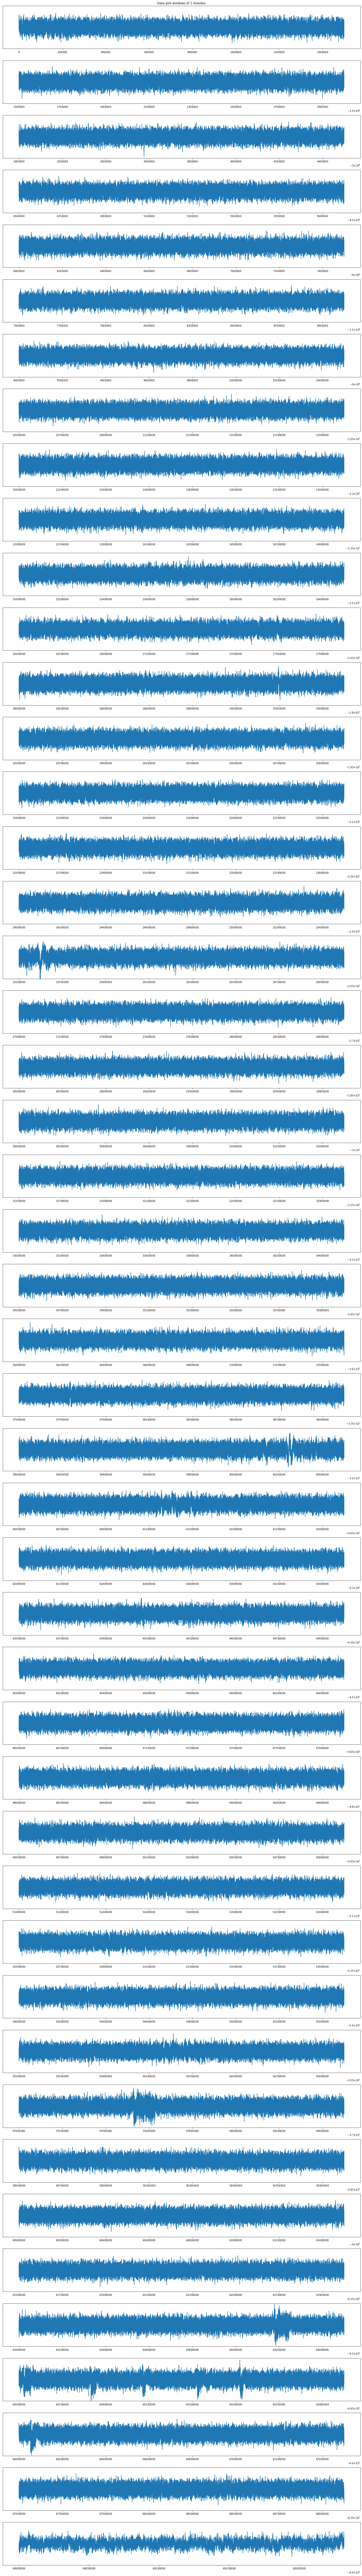

In [ ]:
figura = plot_raw(data, size = 1)